# Cattle Disease Detection using CNN and Transfer Learning

This notebook demonstrates how to classify cattle images into three categories: Mastitis, Lumpy Skin Disease (LSD), and Healthy using a pretrained CNN (ResNet50) with transfer learning. The workflow includes data loading, preprocessing, training, evaluation, inference, and visualization.

In [1]:
# [1] Imports & Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA device count:', torch.cuda.device_count())
    print('CUDA device name:', torch.cuda.get_device_name(0))
print('torch version:', torch.__version__)


Using device: cuda
CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 4060 Laptop GPU
torch version: 2.5.1+cu121


In [3]:
# [2] Dataset & DataLoader
# Define data directories
train_dir = 'C:/Users/HENY/Downloads/SiH2025H/Train-20250913T114441Z-1-001/Train'
val_dir = 'C:/Users/HENY/Downloads/SiH2025H/val-20250913T114440Z-1-001/val'

# ImageNet mean and std
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Data augmentation and transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Class names
class_names = train_dataset.classes
print('Classes:', class_names)

Classes: ['healthy', 'lsd', 'maltitis']


In [4]:
# [3] Model Definition
# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

model = model.to(device)
print(model)

C:\Users\HENY\Downloads\SiH2025H\.venv1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HENY\Downloads\SiH2025H\.venv1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\HENY/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:09<00:00, 10.9MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
# [4] Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=5e-5)
num_epochs = 100

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f}')

Epoch 1/100 - Train Loss: 0.1562 - Train Acc: 0.9528
Epoch 2/100 - Train Loss: 0.1570 - Train Acc: 0.9528
Epoch 3/100 - Train Loss: 0.1583 - Train Acc: 0.9542
Epoch 4/100 - Train Loss: 0.1581 - Train Acc: 0.9542
Epoch 5/100 - Train Loss: 0.1442 - Train Acc: 0.9583
Epoch 6/100 - Train Loss: 0.1541 - Train Acc: 0.9528
Epoch 7/100 - Train Loss: 0.1640 - Train Acc: 0.9528
Epoch 8/100 - Train Loss: 0.1429 - Train Acc: 0.9583
Epoch 9/100 - Train Loss: 0.1709 - Train Acc: 0.9472
Epoch 10/100 - Train Loss: 0.1587 - Train Acc: 0.9556
Epoch 11/100 - Train Loss: 0.1469 - Train Acc: 0.9556
Epoch 12/100 - Train Loss: 0.1523 - Train Acc: 0.9500
Epoch 13/100 - Train Loss: 0.1765 - Train Acc: 0.9319
Epoch 14/100 - Train Loss: 0.1466 - Train Acc: 0.9583
Epoch 15/100 - Train Loss: 0.1347 - Train Acc: 0.9611
Epoch 16/100 - Train Loss: 0.1520 - Train Acc: 0.9528
Epoch 17/100 - Train Loss: 0.1478 - Train Acc: 0.9444
Epoch 18/100 - Train Loss: 0.1372 - Train Acc: 0.9653
Epoch 19/100 - Train Loss: 0.1437 - T

In [18]:
# [5] Validation
# Validation after each epoch
model.eval()
val_running_loss = 0.0
val_running_corrects = 0
val_total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        val_running_loss += loss.item() * inputs.size(0)
        val_running_corrects += torch.sum(preds == labels.data)
        val_total += labels.size(0)
val_epoch_loss = val_running_loss / val_total
val_epoch_acc = val_running_corrects.double() / val_total
val_losses.append(val_epoch_loss)
val_accuracies.append(val_epoch_acc.item())
print(f'Epoch {epoch+1}/{num_epochs} - Val Loss: {val_epoch_loss:.4f} - Val Acc: {val_epoch_acc:.4f}')

Epoch 100/100 - Val Loss: 0.1847 - Val Acc: 0.9167


In [21]:
# [6] Save Model
model_path = 'cattle_cnn.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to cattle_cnn.pth


In [24]:
# [7] Inference on single image
def predict_image(image_path, model, class_names, device):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)
    print(f'Predicted: {class_names[pred.item()]} (Confidence: {conf.item()*100:.2f}%)')
    return class_names[pred.item()], conf.item()

# Example usage:
# predict_image('test.jpg', model, class_names, device)

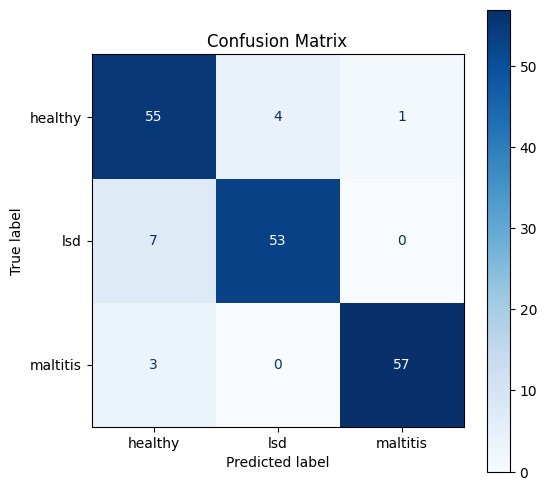

In [25]:
# [8] Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

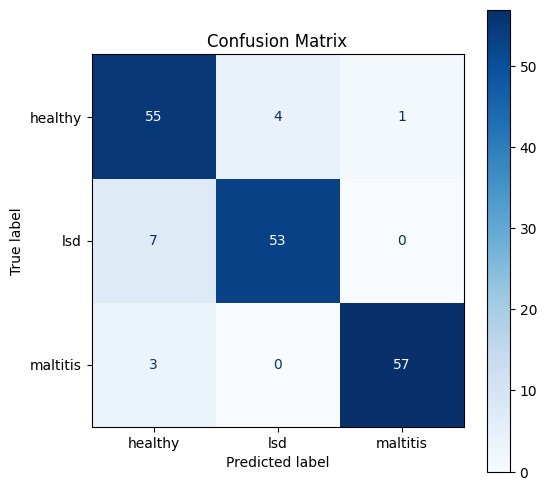

Accuracy: 0.9167
F1 Score: 0.9174


In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Accuracy and F1 Score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')  # use 'macro' if classes are balanced

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# [10] Batch Predict All Test Images Using Trained Model
import os
import glob
from PIL import Image
from torchvision import transforms
import torch

# 1. Load model architecture and weights
model = torch.hub.load('pytorch/vision', 'resnet50', pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)  # 3 classes: Mastitis, LSD, Healthy
model_path = os.path.join('..', 'Model', 'cattle_cnn.pth')
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# 2. Define transform (must match training)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
 ])

# 3. Predict all test images (recursively, all images in subfolders)
test_folder = '../Disease Data/test'
image_paths = glob.glob(os.path.join(test_folder, '**', '*.*'), recursive=True)
class_names = ['healthy', 'lsd', 'mastitis']  # Update if needed
results = []

for img_path in image_paths:
    if not img_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        continue
    try:
        img = Image.open(img_path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0)
        with torch.no_grad():
            output = model(input_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
            disease_name = class_names[predicted_class]
        results.append((os.path.relpath(img_path, test_folder), disease_name))
    except Exception as e:
        results.append((os.path.relpath(img_path, test_folder), f'Error: {e}'))

for fname, pred in results:
    print(f'{fname}: {pred}')

Using cache found in C:\Users\admin/.cache\torch\hub\pytorch_vision_main


001_26_IMG_antibioticcow_creditHenkRiswick_beeldbank-848x565.jpg: healthy
How-to-prevent-mastitis-in-dairy-cows.jpg: healthy
images.jpeg: healthy
lead5_lumpy_skin_cattle.jpg: lsd
